In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

In [2]:
df=pd.read_csv('./train.csv')
df.shape

(404290, 6)

In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [17]:
df.groupby("is_duplicate")["id"].count()

is_duplicate
0    255027
1    149263
Name: id, dtype: int64

In [18]:
percentage_1=149263/(149263+255027)
percentage_0=255027/(149263+255027)
print("Percentage of dublicated questions is %d ",percentage_1)

Percentage of dublicated questions is %d  0.369197853026293


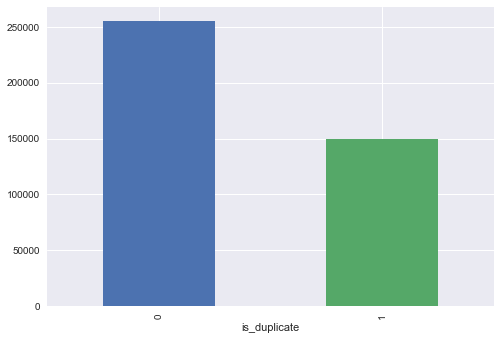

In [20]:
import seaborn as sns
plt.style.use("seaborn")
df.groupby("is_duplicate")['id'].count().plot.bar()
plt.show()

In [28]:
qids=pd.Series(df['qid1'].tolist()+df['qid2'].tolist())
print(qids)

0              1
1              3
2              5
3              7
4              9
5             11
6             13
7             15
8             17
9             19
10            21
11            23
12            25
13            27
14            29
15            31
16            33
17            35
18            37
19            39
20            41
21            43
22            45
23            47
24            49
25            51
26            53
27            55
28            57
29            59
           ...  
808550       691
808551    124172
808552    466328
808553    537906
808554    537908
808555     16064
808556    146284
808557    290649
808558    537910
808559    349794
808560     35364
808561    537914
808562     14005
808563    537916
808564     87385
808565    537917
808566    308365
808567    537918
808568    169786
808569    537921
808570    537923
808571     81495
808572     16773
808573    537925
808574    537927
808575    379845
808576    155606
808577    5379

In [24]:
unique_qs = len(np.unique(qids))
print(unique_qs)

537933


In [27]:
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print(qs_morethan_onetime)

111780


In [31]:
print("Total Number of unique questions are %d ",len(np.unique(qids)))

Total Number of unique questions are %d  537933


In [34]:
print("Maximum Number of times a questions appers is ",max(qids.value_counts()))

Maximum Number of times a questions appers is  157


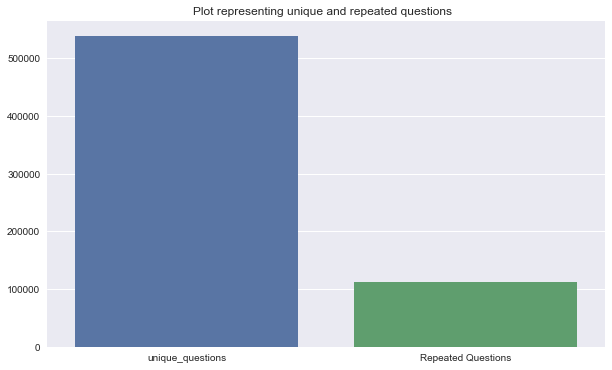

In [38]:

x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]


plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

In [45]:
pair_duplicates = df.groupby(['qid1','qid2']).count().reset_index()

In [46]:
print("Number of dublicates question pairs is",df.shape[0]-len(pair_duplicates))

Number of dublicates question pairs is 0


In [48]:
pair_duplicates.head()

,qid1,qid2,id,question1,question2,is_duplicate
0,1,2,1,1,1,1
1,3,4,1,1,1,1
2,3,282170,1,1,1,1
3,3,380197,1,1,1,1
4,3,488853,1,1,1,1


Maximum number of times a single question is repeated: 157



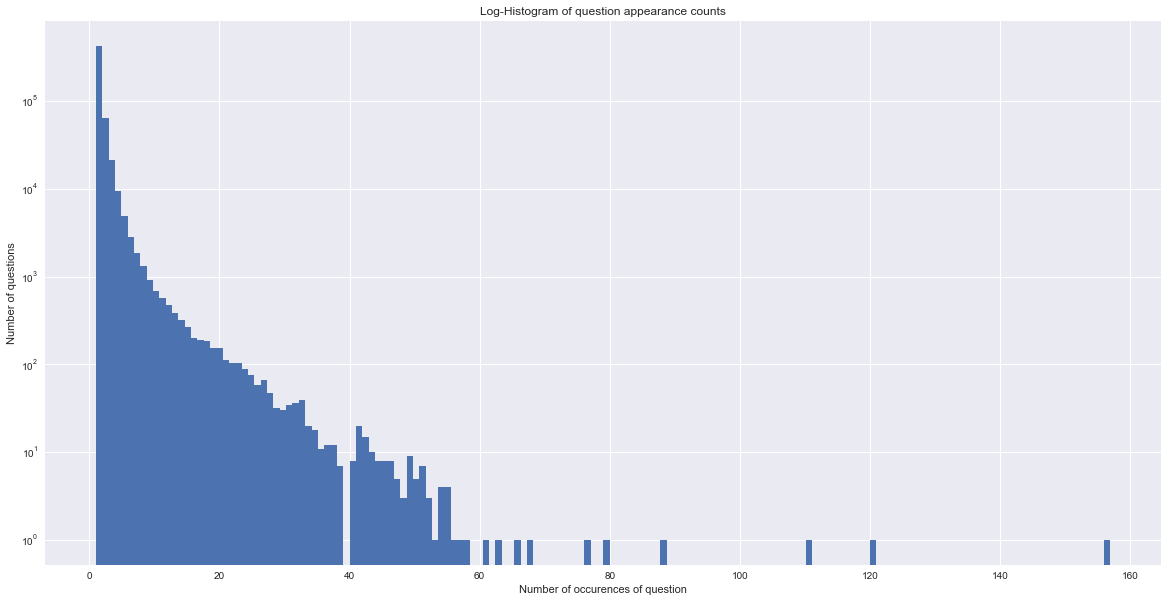

In [49]:
# Number of occurences of each question
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

In [51]:
nan_rows = df[df.isnull().any(1)]
print(nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


In [57]:
df[df.isnull().any(1)]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [58]:
"""
Feature Extraction before cleaning ==>>

Let's now construct a few features like:

freq_qid1 = Frequency of qid1's
freq_qid2 = Frequency of qid2's
q1len = Length of q1
q2len = Length of q2
q1_n_words = Number of words in Question 1
q2_n_words = Number of words in Question 2
word_Common = (Number of common unique words in Question 1 and Question 2)
word_Total =(Total num of words in Question 1 + Total num of words in Question 2)
word_share = (word_common)/(word_Total)
freq_q1+freq_q2 = sum total of frequency of qid1 and qid2
freq_q1-freq_q2 = absolute difference of frequency of qid1 and qid2
"""


if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [59]:
df.shape

(404290, 17)

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 17 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
freq_qid1       404290 non-null int64
freq_qid2       404290 non-null int64
q1len           404290 non-null int64
q2len           404290 non-null int64
q1_n_words      404290 non-null int64
q2_n_words      404290 non-null int64
word_Common     404290 non-null float64
word_Total      404290 non-null float64
word_share      404290 non-null float64
freq_q1+q2      404290 non-null int64
freq_q1-q2      404290 non-null int64
dtypes: float64(3), int64(12), object(2)
memory usage: 52.4+ MB


In [64]:
df['id'].count()

404290

In [65]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1


In [66]:
print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


In [67]:
### So, there are total 67 questions in question_1 an 24 in the other whose length is 1.
### And they are --->
print(df[df['q1_n_words']==1])

            id    qid1    qid2  question1  \
3306      3306    6553    6554          .   
13016    13016   25026   25027          ?   
17682    17682   33561   33562    deleted   
20794    20794   39204   39205          ?   
23305    23305   33561   43661    deleted   
23884    23884   44699   44700         HH   
25228    25228   47035   47036      What?   
25315    25315   47198   29712    deleted   
39769    39769   33561   72063    deleted   
44619    44619   80055   80056         Na   
57484    57484  101005  101006    grammar   
63712    63712   83329  110823      What?   
86457    86457  145814   81121        Is?   
87861    87861  147899  147900   Deleted.   
96725    96725  161071  161072          ?   
104101  104101  171925  171926          ?   
106577  106577   47035  175527      What?   
108978  108978  178936  178937          i   
109311  109311  179423  179424       What   
115347  115347  188110   52215          o   
134403  134403  214814  214815          ?   
139219  13

C:\Users\acer\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



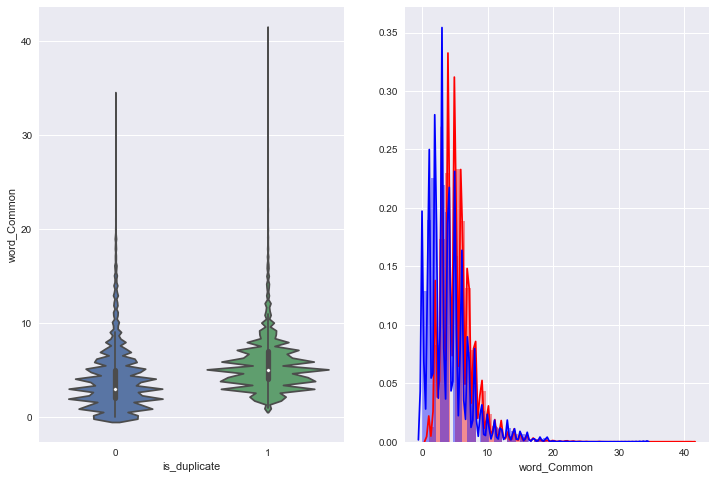

In [68]:
### Word_common Feature Analysis
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

In [69]:
### So, we can see word_common feature on similar and non-similar words are much overlapping.
###
###
###